## TC 5033
## Deep Learning
## Transformers

#### Activity 4: Implementing a Translator

- Objective

To understand the Transformer Architecture by Implementing a translator.

- Instructions

    This activity requires submission in teams. While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Follow the provided code. The code already implements a transformer from scratch as explained in one of [week's 9 videos](https://youtu.be/XefFj4rLHgU)

    Since the provided code already implements a simple translator, your job for this assignment is to understand it fully, and document it using pictures, figures, and markdown cells.  You should test your translator with at least 10 sentences. The dataset used for this task was obtained from [Tatoeba, a large dataset of sentences and translations](https://tatoeba.org/en/downloads).
  
- Evaluation Criteria

    - Code Readability and Comments
    - Traning a translator
    - Translating at least 10 sentences.

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.



#####Team 27 Members:

- Juan Antonio Chiñas Mata: A01794191
- José Alejandro Cortés Pérez: A01795033
- Moises Flores Ortíz: A01795489
- Mardonio Manuel Román Ramírez: A01795265
- Miriam Eunice Rosas Medellín: A01795550

#####Evaluation:

- **Code Commenting:**
The clarity, accuracy, and thoroughness of comments explaining the provided code. You are suggested to use markdown cells for your explanations.
- **Translator functionality:**
A working model is provided. You are free to use it as long as you make sure to uderstand it, you may as well improve it as you see fit. The minimum expected is to provide comments for the given function.
- **Test translator with > 10 short sentences:**
You test your model with >10 short sentences, the quality of the translation is not evaluated.
- **Conclusions:**
You may include any insight you consider relevant, such the performance of the model on such a limited dataset and compute power, quality of translation, or any other aspect you consider relevant.

######Dataset obtained from:

https://www.google.com/url?q=https%3A%2F%2Ftatoeba.org%2Fen%2Fdownloads


###Environment of choice

Given that this model architecture requires a robust set of computational resources, the environment of choice for the execution of the following exercise was:
- Colab Pro
- A100 GPU
- High-RAM configuration

With the above settings for a full run of the below cells, the consumption was around 12 compute units as specified [here](https://colab.research.google.com/signup).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Script to convert csv to text file

To convert the tab-separated file into a csv, a spreadsheet application was used, however the encoding in the sentences was **Windows 1252**, therefore it had to be specified in the `read_csv` function.

The csv data file used in the exercise can be downloaded [here](https://drive.google.com/file/d/1SKHLzhDTdF5SPJgR4UkR4QMi9zSGvmMj/view?usp=sharing).

Additionally, as Colab was the environment of choice the path is relative to a Google Drive mount. To successfully re-run this notebook, the `PATH` variable would need to be adjusted to the applicable working directory or a similar PATH is to be created in the user's Google Drive.

In [ ]:
#This script requires to convert the TSV file to CSV
# easiest way is to open it in Calc or excel and save as csv

PATH = '/content/drive/MyDrive/DeepLearning/sentences_eng_spa_2024.csv'
import pandas as pd
df = pd.read_csv(PATH, encoding='cp1252') # Added the cp1252 encoding

### Dataset Preprocessing

We extract columns in positions 1 & 3 which correspond with the english and spanish sentences respectively. See the example below:

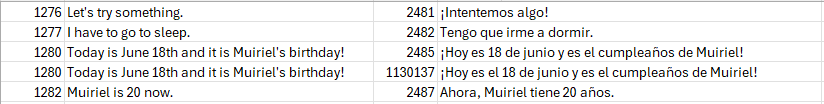

Then, we calculate the length in order to sort the sentences by this property and store the output in a text file.

In [ ]:
eng_spa_cols = df.iloc[:, [1, 3]] # Extract the columns 1 & 3
eng_spa_cols['length'] = eng_spa_cols.iloc[:, 0].str.len()   # Add a length column for each sentence in the source language
eng_spa_cols = eng_spa_cols.sort_values(by='length')  # Sort by length
eng_spa_cols = eng_spa_cols.drop(columns=['length'])  # Drop the aux length column

# Save the resulting data into a text file in Google Drive
output_file_path = '/content/drive/MyDrive/DeepLearning/eng-spa4.txt'
eng_spa_cols.to_csv(output_file_path, sep='\t', index=False, header=False)

<ipython-input-3-ca910e64b7d7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_spa_cols['length'] = eng_spa_cols.iloc[:, 0].str.len()


## Transformer - Attention is all you need

In [ ]:
# Required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import math
import numpy as np
import re

torch.manual_seed(23)

**NOTE:**

It is highly recommended to use a GPU for the training of the below model.

In [ ]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# The maximum length of any sentence used in the training corpus
MAX_SEQ_LEN = 128

### Model Architecture

The model architecture chosen in this exercise is inspired in the original architecture proposed in the "Attention is all you need" paper (https://arxiv.org/abs/1706.03762).

The architecture is based on one encoder and one decoder blocks connected through an Attention Mechanism and dispose from the previously standard use of Recurrent and Convolutional components in transduction models.

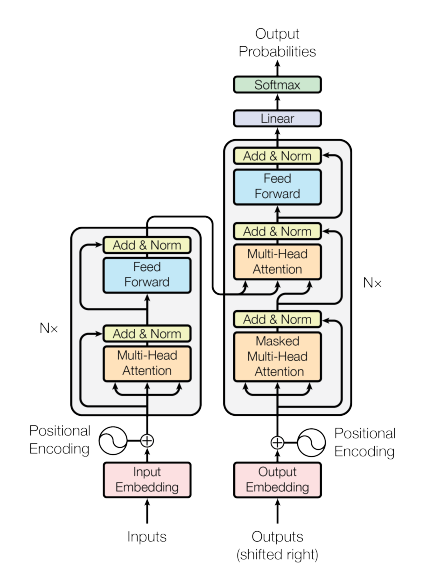

### Design approach

A block design approach was taken with each of the blocks depicted in the architecture above being represented by a class that inherits from PyTorch's `nn.Module`. The outtermost class represents at a higher level abstraction the Transformer itself and it breaks down into an encoder and decoder that implement their inner components as classes themselves.






### Relevant architecture attributes

- `num_layers`: The number of times that the encoder and decoder blocks are repeated.
- `d_model`: It's a multi-purpose attribute used for the embeddings size and to represent the dimensions of several of the components within the architecture. A single value is used to help homogenize the sizes of the Tensors used in calculations and minimize the size compatibility issues in-between layers.
- `num_heads`: The number of times that the attention mechanism is calculated for each of the multi-head attention layers.
- `d_ff`: The feed forward hidden layer size.
- `input_vocab_size`: The length of the source vocabulary in word counts.
- `output_vocab_size`: The length of the target vocabulary in word counts.
- `MAX_SEQ_LEN`: The maximum length of any sentence used in the training corpus
- `dropout`: The proportion of dropout to use



### Block components

####Transformer
- Class: **Transformer**
- Description: Outermost component that receives all of the relevant architecture attributes and passes them down to all the appropriate sub-components. Includes the embeddings layers that are used as inputs for both the `Encoder` & `Decoder`. This class also specifies the positional encoding used as input for the encoder and decoder. Lastly, it passes the results obtained from the decoder through a Linear layer that it defines itself.

####Positional Encoding
- Class: **PositionalEmbedding**
- Description: This layer uses a series of sine and cosine functions to encode the position of each of the embeddings in the passed sequences. Transformers process words simultaneously, therefore the transformer requires a mechanism through which it can recover the position of each of the embeddings after they been passed through.

####Multi-Head Attention
- Class: **MultiHeadAttention**
- Description: Performs the attention calculations on the input positional embeddings by calculating a Query, Key and Value matrices and then performing a Scaled-Dot-Product Attention operation between the Queries and Keys of each embedding in the sequence. This operation is repeated equal to the `num_heads` attribute.

####Feed Forward
- Class: **PositionFeedForward**
- Description: A series of two Fully-Connected layers passed through a ReLU activation function in between. The dimensionality of input and output is `d_model` and the inner_layer is `d_ff`.

####Encoder
- Class: **Encoder**
- Description: The encoder component contains `num_layers` times `EncoderSubLayer` and they are passed through a normalization stage to generate it's output.

####Encoder (Inner components)
- Class: **EncoderSubLayer**
- Description: Integrates the Attention mechanism with the feed forward stage for each of the stacks defined by `num_layers`. It defines a residual connection that feeds the input bypassing the Multi-Head Attention Layer and performs appropriate normalization and dropout operations after each of the Attention and FF stages. Notice how here, self-attention is implemented, where only the encoder inputs are considered within the MHA block.

####Decoder
- Class: **Decoder**
- Description: The decoder component contains `num_layers` times `DecoderSubLayer` and they are passed through a normalization stage to generate it's output.

####Decoder (Inner components)
- Class: **DecoderSubLayer**
- Description: Integrates the Attention mechanism with the feed forward stage for each of the stacks defined by `num_layers`. It defines a residual connection that feeds the input bypassing the Multi-Head Attention Layer and performs appropriate normalization and dropout operations after each of the Attention and FF stages. Notice how here, both self-attention and cross-attention are implemented. In the cross-attention block, the output of the encoder are considered within the middle attention block. Lastly, in the decoder the input to the self-attention block are masked to prevent the attention mechanism from "seeing" beyond the current word.

Let's define the above classes:

In [ ]:
class PositionalEmbedding(nn.Module):
    """
    Positional Encoding class.

    Args:
        d_model (int): The size of the embedding vectors.
        max_seq_len (int): The maximum sequence length allowed.
    """
    def __init__(self, d_model, max_seq_len = MAX_SEQ_LEN):
        super().__init__()

        # Defines a zeros matrix of the max seq length by the d_model size
        self.pos_embed_matrix = torch.zeros(max_seq_len, d_model, device=device)

        # Token position
        token_pos = torch.arange(0, max_seq_len, dtype = torch.float).unsqueeze(1)

        # The dividing term in the sinusoidal functions
        div_term = torch.exp(torch.arange(0, d_model, 2).float()
                             * (-math.log(10000.0)/d_model))
        # Calculate positional encodings for pairs with sine
        self.pos_embed_matrix[:, 0::2] = torch.sin(token_pos * div_term)

        # Calculate positional encodings for odds with cosine
        self.pos_embed_matrix[:, 1::2] = torch.cos(token_pos * div_term)

        # Alignment and size compatibility transformations
        self.pos_embed_matrix = self.pos_embed_matrix.unsqueeze(0).transpose(0,1)

    def forward(self, x):
        # Add the positional encoding to the input embeddings
        return x + self.pos_embed_matrix[:x.size(0), :]

class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention class.

    Args:
        d_model (int): The size of the embedding vectors.
        num_heads (int): Number of heads (scaled-dot-product attention operations).
    """
    def __init__(self, d_model = 512, num_heads = 8):
        super().__init__()

        # Ensure num_heads is a factor of d_model
        assert d_model % num_heads == 0, 'Embedding size not compatible with num heads'

        # Integer division
        self.d_v = d_model // num_heads
        self.d_k = self.d_v
        self.num_heads = num_heads

        # W_q, W_k, W_v and W_o are just a single layer FC network of d_model size
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask = None):
        batch_size = Q.size(0)
        '''
        Q, K, V -> [batch_size, seq_len, num_heads*d_k]
        after transpose Q, K, V -> [batch_size, num_heads, seq_len, d_k]
        '''
        # Perform the forward pass between the weights and Q, K & V
        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2 )
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2 )
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2 )

        # Perform the attention scaled-dot-product
        weighted_values, attention = self.scale_dot_product(Q, K, V, mask)

        # Concatenate the results
        weighted_values = weighted_values.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads*self.d_k)

        # Pass through the output Linear layer
        weighted_values = self.W_o(weighted_values)

        return weighted_values, attention


    def scale_dot_product(self, Q, K, V, mask = None):
        # Obtain all Q dot K results in one go through a matrix multiplication
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply the mask if applicable
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Softmax to obtain the probability distribution
        attention = F.softmax(scores, dim = -1)

        # Softmaxed result times V
        weighted_values = torch.matmul(attention, V)

        return weighted_values, attention


class PositionFeedForward(nn.Module):
    """
    Feed Forward class

    Args:
        d_model (int): The size of the embedding vectors.
        d_ff (int): Hidden layer size.
    """
    def __init__(self, d_model, d_ff):
        super().__init__()

        # Input layer
        self.linear1 = nn.Linear(d_model, d_ff)

        # Output layer of same size as input
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # Pass through both layers with a ReLU activation in between
        return self.linear2(F.relu(self.linear1(x)))

class EncoderSubLayer(nn.Module):
    """
    Encoder SubLayer class.

    Args:
        d_model (int): The size of the embedding vectors.
        num_heads (int): Number of heads (scaled-dot-product attention operations).
        d_ff (int): Hidden layer size.
        dropout (float): The proportion of dropout to use.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout = 0.1):
        super().__init__()

        # Init the inner blocks
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.droupout1 = nn.Dropout(dropout)
        self.droupout2 = nn.Dropout(dropout)

    def forward(self, x, mask = None):
        # Pass through the self attention block passing in the inputs as Q, K & V
        attention_score, _ = self.self_attn(x, x, x, mask)

        # Residual connection with dropout
        x = x + self.droupout1(attention_score)

        # Normalization
        x = self.norm1(x)

        # Residual connection with dropout after a Position Feed Forward pass
        x = x + self.droupout2(self.ffn(x))

        # Normalization
        return self.norm2(x)

class Encoder(nn.Module):
    """
    Encoder class.

    Args:
        d_model (int): The size of the embedding vectors.
        num_heads (int): Number of heads (scaled-dot-product attention operations).
        d_ff (int): Hidden layer size.
        num_layers (int): The number of times that the encoder block is repeated.
        dropout (float): The proportion of dropout to use.
    """
    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        super().__init__()

        # Initialize EncoderSubLayers equal to the value of num_layers
        self.layers = nn.ModuleList([EncoderSubLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        # Normalization
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        # Pass through for each of the SubLayers (THIS STEP IS PARALELIZABLE!!)
        for layer in self.layers:
            x = layer(x, mask)
        # Normalization
        return self.norm(x)

class DecoderSubLayer(nn.Module):
    """
    Decoder SubLayer class.

    Args:
        d_model (int): The size of the embedding vectors.
        num_heads (int): Number of heads (scaled-dot-product attention operations).
        d_ff (int): Hidden layer size.
        dropout (float): The proportion of dropout to use.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # Init the inner blocks
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, encoder_output, target_mask=None, encoder_mask=None):
        # Pass through the self attention block passing in the inputs as Q, K & V, here we will use a mask
        attention_score, _ = self.self_attn(x, x, x, target_mask)

        # Residual connection with dropout
        x = x + self.dropout1(attention_score)

        # Normalization
        x = self.norm1(x)

        # Cross-Attention using the encoder output for Q and K and it's inputs for V
        encoder_attn, _ = self.cross_attn(x, encoder_output, encoder_output, encoder_mask)

        # Residual connection with dropout
        x = x + self.dropout2(encoder_attn)

        # Normalization
        x = self.norm2(x)

        # Feed Forward Pass
        ff_output = self.feed_forward(x)

        # Residual connection with dropout
        x = x + self.dropout3(ff_output)

        # Normalization
        return self.norm3(x)

class Decoder(nn.Module):
    """
    Decoder class.

    Args:
        d_model (int): The size of the embedding vectors.
        num_heads (int): Number of heads (scaled-dot-product attention operations).
        d_ff (int): Hidden layer size.
        num_layers (int): The number of times that the decoder block is repeated.
        dropout (float): The proportion of dropout to use.
    """
    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        super().__init__()

        # Initialize EncoderSubLayers equal to the value of num_layers
        self.layers = nn.ModuleList([DecoderSubLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        # Normalization
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, encoder_output, target_mask, encoder_mask):
        # Pass through for each of the SubLayers (THIS STEP IS PARALELIZABLE!!)
        for layer in self.layers:
            x = layer(x, encoder_output, target_mask, encoder_mask)
        # Normalization
        return self.norm(x)

In [ ]:
class Transformer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers,
                 input_vocab_size, target_vocab_size,
                 max_len=MAX_SEQ_LEN, dropout=0.1):
        super().__init__()

        # Init inner blocks
        self.encoder_embedding = nn.Embedding(input_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(target_vocab_size, d_model)
        self.pos_embedding = PositionalEmbedding(d_model, max_len)
        self.encoder = Encoder(d_model, num_heads, d_ff, num_layers, dropout)
        self.decoder = Decoder(d_model, num_heads, d_ff, num_layers, dropout)
        self.output_layer = nn.Linear(d_model, target_vocab_size)

    def forward(self, source, target):
        # Encoder mask
        source_mask, target_mask = self.mask(source, target)
        # Embedding and positional Encoding
        source = self.encoder_embedding(source) * math.sqrt(self.encoder_embedding.embedding_dim)
        source = self.pos_embedding(source)
        # Encoder
        encoder_output = self.encoder(source, source_mask)

        # Decoder embedding and postional encoding
        target = self.decoder_embedding(target) * math.sqrt(self.decoder_embedding.embedding_dim)
        target = self.pos_embedding(target)
        # Decoder
        output = self.decoder(target, encoder_output, target_mask, source_mask)

        return self.output_layer(output)



    def mask(self, source, target):
        # Prepare source and target masks
        source_mask = (source != 0).unsqueeze(1).unsqueeze(2)
        target_mask = (target != 0).unsqueeze(1).unsqueeze(2)
        size = target.size(1)
        no_mask = torch.tril(torch.ones((1, size, size), device=device)).bool()
        target_mask = target_mask & no_mask
        return source_mask, target_mask


#### Simple test

The following test just confirms that the sizes match for the complete pass through the transformer by mocking a test embedding and forwarding it.

In [ ]:
seq_len_source = 10
seq_len_target = 10
batch_size = 2
input_vocab_size = 50
target_vocab_size = 50

source = torch.randint(1, input_vocab_size, (batch_size, seq_len_source))
target = torch.randint(1, target_vocab_size, (batch_size, seq_len_target))

In [ ]:
d_model = 512
num_heads = 8
d_ff = 2048
num_layers = 6

model = Transformer(d_model, num_heads, d_ff, num_layers,
                  input_vocab_size, target_vocab_size,
                  max_len=MAX_SEQ_LEN, dropout=0.1)

model = model.to(device)
source = source.to(device)
target = target.to(device)

In [ ]:
output = model(source, target)

In [ ]:
# Expected output shape -> [batch, seq_len_target, target_vocab_size] i.e. [2, 10, 50]
print(f'ouput.shape {output.shape}')

ouput.shape torch.Size([2, 10, 50])


### Translator Eng-Spa

In [ ]:
PATH = '/content/drive/MyDrive/DeepLearning/eng-spa4.txt'

In [ ]:
with open(PATH, 'r', encoding='utf-8') as f:
    lines = f.readlines()
eng_spa_pairs = [line.strip().split('\t') for line in lines if '\t' in line]

In [ ]:
eng_spa_pairs[:10]

[['Go.', 'Vete.'],
 ['Go.', 'Vaya.'],
 ['Go!', '¡Ve!'],
 ['Go!', '¡Ya!'],
 ['Hi.', 'Hola.'],
 ['Go!', '¡Sal!'],
 ['Go.', 'Váyase.'],
 ['Go!', '¡Fuera!'],
 ['No.', 'No.'],
 ['Go!', 'Váyase']]

In [ ]:
eng_sentences = [pair[0] for pair in eng_spa_pairs]
spa_sentences = [pair[1] for pair in eng_spa_pairs]

In [ ]:
print(eng_sentences[:10])
print(spa_sentences[:10])


['Go.', 'Go.', 'Go!', 'Go!', 'Hi.', 'Go!', 'Go.', 'Go!', 'No.', 'Go!']
['Vete.', 'Vaya.', '¡Ve!', '¡Ya!', 'Hola.', '¡Sal!', 'Váyase.', '¡Fuera!', 'No.', 'Váyase']


#### Preprocessing part 2

Before we process our sentences we must first cleanse the input. This will dramatically reduce the complexity and will allow our model to generalize better as special characters and punctuation and casing will all be moved out of the picture, effectively reducing the universe of character combinations that our model will have to learn to predict.

We will convert everything to lowercase remove special tokens, accentuated characters and all special characters.

Additionally, we add the start of sentence and end of sentence tokens.

In [ ]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[á]+", "a", sentence)
    sentence = re.sub(r"[é]+", "e", sentence)
    sentence = re.sub(r"[í]+", "i", sentence)
    sentence = re.sub(r"[ó]+", "o", sentence)
    sentence = re.sub(r"[ú]+", "u", sentence)
    sentence = re.sub(r"[^a-z]+", " ", sentence)
    sentence = sentence.strip()
    sentence = '<sos> ' + sentence + ' <eos>'
    return sentence

In [ ]:
s1 = '¿Hola @ cómo estás? 123'

In [ ]:
print(s1)
print(preprocess_sentence(s1))

¿Hola @ cómo estás? 123
<sos> hola como estas <eos>


In [ ]:
eng_sentences = [preprocess_sentence(sentence) for sentence in eng_sentences]
spa_sentences = [preprocess_sentence(sentence) for sentence in spa_sentences]

In [ ]:
spa_sentences[:10]

['<sos> vete <eos>',
 '<sos> vaya <eos>',
 '<sos> ve <eos>',
 '<sos> ya <eos>',
 '<sos> hola <eos>',
 '<sos> sal <eos>',
 '<sos> vayase <eos>',
 '<sos> fuera <eos>',
 '<sos> no <eos>',
 '<sos> vayase <eos>']

In [ ]:
# Building the indexed vocabularies as maps
def build_vocab(sentences):
    words = [word for sentence in sentences for word in sentence.split()]
    word_count = Counter(words)
    sorted_word_counts = sorted(word_count.items(), key=lambda x:x[1], reverse=True)
    word2idx = {word: idx for idx, (word, _) in enumerate(sorted_word_counts, 2)}
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    idx2word = {idx: word for word, idx in word2idx.items()}
    return word2idx, idx2word

In [ ]:
eng_word2idx, eng_idx2word = build_vocab(eng_sentences)
spa_word2idx, spa_idx2word = build_vocab(spa_sentences)
eng_vocab_size = len(eng_word2idx)
spa_vocab_size = len(spa_word2idx)

In [ ]:
print(eng_vocab_size, spa_vocab_size)

27660 46955


#### Dataset creation

To create our dataset, we inherit from `Dataset` and implement both the `__len__()` and the `__getitem__()` methods.

In [ ]:
class EngSpaDataset(Dataset):
    def __init__(self, eng_sentences, spa_sentences, eng_word2idx, spa_word2idx):
        self.eng_sentences = eng_sentences
        self.spa_sentences = spa_sentences
        self.eng_word2idx = eng_word2idx
        self.spa_word2idx = spa_word2idx

    def __len__(self):
        return len(self.eng_sentences)

    def __getitem__(self, idx):
        eng_sentence = self.eng_sentences[idx]
        spa_sentence = self.spa_sentences[idx]
        # return tokens idxs
        eng_idxs = [self.eng_word2idx.get(word, self.eng_word2idx['<unk>']) for word in eng_sentence.split()]
        spa_idxs = [self.spa_word2idx.get(word, self.spa_word2idx['<unk>']) for word in spa_sentence.split()]

        return torch.tensor(eng_idxs), torch.tensor(spa_idxs)

#### Collate function

Defines how we go about pidding and creating our batches for training.

In [1]:
# Collate function to be used inside our dataloader
def collate_fn(batch):
    eng_batch, spa_batch = zip(*batch)
    eng_batch = [seq[:MAX_SEQ_LEN].clone().detach() for seq in eng_batch]
    spa_batch = [seq[:MAX_SEQ_LEN].clone().detach() for seq in spa_batch]
    eng_batch = torch.nn.utils.rnn.pad_sequence(eng_batch, batch_first=True, padding_value=0)
    spa_batch = torch.nn.utils.rnn.pad_sequence(spa_batch, batch_first=True, padding_value=0)
    return eng_batch, spa_batch


#### Training Function

- Sends to device (GPU if possible)
- Extracts the target input and output
- Passes the source language batch to the model
- Calculates a loss based on the outputs relationship with the target input
- Backpropagates
- Steps with an optimizer

The training function continues for a set number of epochs.

In [ ]:
# Typical training function
def train(model, dataloader, loss_function, optimiser, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for i, (eng_batch, spa_batch) in enumerate(dataloader):
            eng_batch = eng_batch.to(device)
            spa_batch = spa_batch.to(device)
            # Decoder preprocessing
            target_input = spa_batch[:, :-1]
            target_output = spa_batch[:, 1:].contiguous().view(-1)
            # Zero grads
            optimiser.zero_grad()
            # run model
            output = model(eng_batch, target_input)
            output = output.view(-1, output.size(-1))
            # loss\
            loss = loss_function(output, target_output)
            # gradient and update parameters
            loss.backward()
            optimiser.step()
            total_loss += loss.item()

        avg_loss = total_loss/len(dataloader)
        print(f'Epoch: {epoch}/{epochs}, Loss: {avg_loss:.4f}')



In [ ]:
# Batch properties and preparation
BATCH_SIZE = 64
dataset = EngSpaDataset(eng_sentences, spa_sentences, eng_word2idx, spa_word2idx)

# Wrapping it in a Dataloader for ease of use
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [ ]:
# Instantiates the model
model = Transformer(d_model=512, num_heads=8, d_ff=2048, num_layers=6,
                    input_vocab_size=eng_vocab_size, target_vocab_size=spa_vocab_size,
                    max_len=MAX_SEQ_LEN, dropout=0.1)

In [ ]:
# GPU if possible
model = model.to(device)

# Cross Entropy Loss
loss_function = nn.CrossEntropyLoss(ignore_index=0)

# Standard Adam optimizer
optimiser = optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
# Train the model for 10 epochs
train(model, dataloader, loss_function, optimiser, epochs = 10)

Epoch: 0/10, Loss: 3.5955
Epoch: 1/10, Loss: 2.2003
Epoch: 2/10, Loss: 1.7018
Epoch: 3/10, Loss: 1.3758
Epoch: 4/10, Loss: 1.1259
Epoch: 5/10, Loss: 0.9234
Epoch: 6/10, Loss: 0.7597
Epoch: 7/10, Loss: 0.6304
Epoch: 8/10, Loss: 0.5364
Epoch: 9/10, Loss: 0.4671


### Evaluation

We create a set of utility functions to test our translation capabilities.

In [ ]:
def sentence_to_indices(sentence, word2idx):
    return [word2idx.get(word, word2idx['<unk>']) for word in sentence.split()]

def indices_to_sentence(indices, idx2word):
    return ' '.join([idx2word[idx] for idx in indices if idx in idx2word and idx2word[idx] != '<pad>'])

def translate_sentence(model, sentence, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device='cpu'):
    model.eval()
    sentence = preprocess_sentence(sentence)
    input_indices = sentence_to_indices(sentence, eng_word2idx)
    input_tensor = torch.tensor(input_indices).unsqueeze(0).to(device)

    # Initialize the target tensor with <sos> token
    tgt_indices = [spa_word2idx['<sos>']]
    tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(max_len):
            output = model(input_tensor, tgt_tensor)
            output = output.squeeze(0)
            next_token = output.argmax(dim=-1)[-1].item()
            tgt_indices.append(next_token)
            tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)
            if next_token == spa_word2idx['<eos>']:
                break

    return indices_to_sentence(tgt_indices, spa_idx2word)

In [ ]:
def evaluate_translations(model, sentences, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device='cpu'):
    for sentence in sentences:
        translation = translate_sentence(model, sentence, eng_word2idx, spa_idx2word, max_len, device)
        print(f'Input sentence: {sentence}')
        print(f'Traducción: {translation}')
        print()

# Example sentences to test the translator
test_sentences = [
    "Hello, how are you?",
    "I am learning artificial intelligence.",
    "Artificial intelligence is great.",
    "Good night!",
    "When is dinner time?",
    "My cat's name is Blondie",
    "The high school opera was awesome",
    "I study in the morning",
    "He walks through the mall on Satudays",
    "Deep Learning is very useful",
    "Winter is my favorite season",
    "I enjoy water more than sweet beverages",
    "I play basketball on Sundays",
    "The news don't always show local events",
    "Cellphones distract us from reading"
]

# Assuming the model is trained and loaded
# Set the device to 'cpu' or 'cuda' as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Evaluate translations
evaluate_translations(model, test_sentences, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device=device)


Input sentence: Hello, how are you?
Traducción: <sos> hola como estas <eos>

Input sentence: I am learning artificial intelligence.
Traducción: <sos> estoy aprendiendo inteligencia artificial <eos>

Input sentence: Artificial intelligence is great.
Traducción: <sos> la inteligencia artificial es buena <eos>

Input sentence: Good night!
Traducción: <sos> buenas noches <eos>

Input sentence: When is dinner time?
Traducción: <sos> cuando es la hora de cenar <eos>

Input sentence: My cat's name is Blondie
Traducción: <sos> el nombre de mi gato es masculino <eos>

Input sentence: The high school opera was awesome
Traducción: <sos> la opera fue bien secundaria <eos>

Input sentence: I study in the morning
Traducción: <sos> estudio por la ma ana <eos>

Input sentence: He walks through the mall on Satudays
Traducción: <sos> el se da a traves del centro comercial <eos>

Input sentence: Deep Learning is very useful
Traducción: <sos> aprender es muy util <eos>

Input sentence: Winter is my favori

#### Conclusions

1. Training a robust transformer is computationally expensive. For this simple example, a A100 GPU was used in a Google Cloud setting, taking around 45 [min] to complete 10 epochs of training.

2. The data required to build a robust transformer for translation purposes must be large. The reason we conclude this is because it is helpful for the model to see each word being used in different situations and paired with as many words as possible for out model to accurately capture the uses and relationships with other words.

3. One important observation we have for this type of model is that a confidence score is not easily retrieved from this type of architecture. In contrast to a classification model where the output class is predicted with a probability score this architecture predict the next "most likely" token for each one of the tokens produced, therefore extracting a single "confidence" value is not obtained in a straightforward fashion.